In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import copy

import seaborn as sns
from matplotlib import pyplot as plt

import torch
cuda = torch.cuda.is_available()
print("GPU:", cuda)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

from collections import OrderedDict
from scipy import stats
from scipy.stats import gaussian_kde

from copy import deepcopy
import random

GPU: False


In [240]:
COLAB = True

if COLAB is True:
    from google.colab import drive
    drive.mount('/content/drive')
    dir = "/content/drive/MyDrive/Colab_Notebooks/datasets/fashion-mnist_train.csv"
else:
    dir = "../datasets/fashion-mnist_train.csv"
    
train = pd.read_csv(dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
train = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/datasets/fashion-mnist_train.csv")

label_dict = {0:'top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle'}

class_num = len(label_dict)

train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
X = train.iloc[:,1:].values / 255
Y = train.iloc[:,0].values

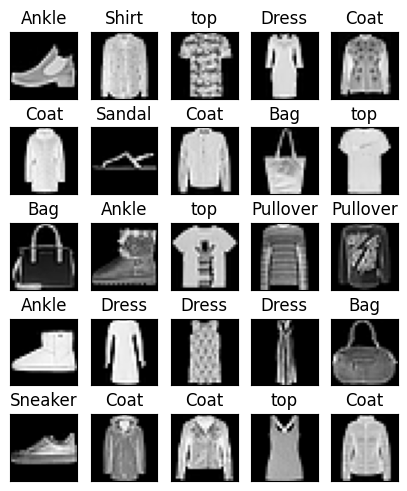

In [4]:
r = 5
c = 5
fig=plt.figure(figsize=(r, c*1.2), dpi=100)
for i in range(1, r*c+1):
    img = X[i].reshape(28,28)
    ax = fig.add_subplot(r, c, i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.title.set_text(label_dict[Y[i]])
    
    plt.imshow(img,cmap='gray')
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

trn_x,val_x,trn_y,val_y = train_test_split(X,Y,test_size=0.2)

In [6]:
#converting our data into a datloader object.

trn_x = torch.from_numpy(trn_x).type(torch.FloatTensor)
trn_y = torch.from_numpy(trn_y).type(torch.LongTensor)

val_x = torch.from_numpy(val_x).type(torch.FloatTensor)
val_y = torch.from_numpy(val_y).type(torch.LongTensor)

In [7]:
from torch.utils.data import TensorDataset,DataLoader

trn = TensorDataset(trn_x,trn_y)
val = TensorDataset(val_x,val_y)

trn = DataLoader(trn,batch_size=1000)
val = DataLoader(val,batch_size=1000)

In [8]:
shape = trn_x[0].shape
shape

torch.Size([784])

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(784,256)
        self.linear2 = nn.Linear(256,100)
        self.linear3 = nn.Linear(100,64)
        self.linear4 = nn.Linear(64,10)
    
    def forward(self,X):
        X1 = F.relu(self.linear1(X))
        X2 = F.relu(self.linear2(X1))
        X3 = F.relu(self.linear3(X2))
        X4 = self.linear4(X3)
        return X1, X2, X3, F.log_softmax(X4, dim=1)

mlp = Model()

if cuda:
    mlp.cuda()
    
print(mlp)    

Model(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=10, bias=True)
)


In [10]:
#define our optimizer
from torch.optim import Adam

optimizer = Adam(mlp.parameters(), lr=1e-3)

In [11]:
def compute_val_loss(val_x,val_y,model):
    if cuda:
        val_x,val_y = val_x.cuda(),val_y.cuda()
    output = model(val_x)[3]
    loss = F.cross_entropy(output,val_y)
    return loss

In [12]:
%%time
EPOCHS = 10

trn_loss = []
val_loss = []

mlp.train()

for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(trn):

        if cuda:
            data,target = data.cuda(),target.cuda()
            
        optimizer.zero_grad()
        
        _, _, _, y_pred = mlp(data)

        loss = F.cross_entropy(y_pred, target)
        trn_loss.append(loss.cpu().data.item())
        
        loss.backward()
        optimizer.step()
        
        loss = compute_val_loss(val_x,val_y,mlp)
        val_loss.append(loss.cpu().data.item())

    print("Epoch: {} | loss: {} | val_loss: {}".format(epoch+1,trn_loss[-1],val_loss[-1]))

Epoch: 1 | loss: 0.671337902545929 | val_loss: 0.6645600199699402
Epoch: 2 | loss: 0.5312770009040833 | val_loss: 0.5294914841651917
Epoch: 3 | loss: 0.47834643721580505 | val_loss: 0.4574716091156006
Epoch: 4 | loss: 0.452067106962204 | val_loss: 0.42486268281936646
Epoch: 5 | loss: 0.43301671743392944 | val_loss: 0.41080132126808167
Epoch: 6 | loss: 0.4144371449947357 | val_loss: 0.3983141779899597
Epoch: 7 | loss: 0.39668864011764526 | val_loss: 0.38665544986724854
Epoch: 8 | loss: 0.38109683990478516 | val_loss: 0.37686827778816223
Epoch: 9 | loss: 0.3668358623981476 | val_loss: 0.36651965975761414
Epoch: 10 | loss: 0.35401973128318787 | val_loss: 0.358297199010849
CPU times: user 1min 18s, sys: 39.3 ms, total: 1min 18s
Wall time: 1min 19s


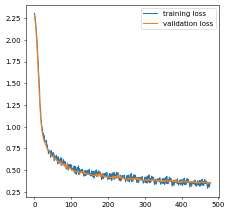

In [13]:
plt.figure(figsize=(5,5),dpi=50)
plt.plot(trn_loss,label='training loss')
plt.plot(val_loss,label='validation loss')
plt.legend(loc='upper right')

In [14]:
def predict(model,val_x,ret_fm=False):
    """
    ret_fm: when set True, return feature map of layers
    """
    if cuda: val_x = val_x.cuda()
    out = model(val_x)
   
    ret = []
    y_preds = []
    if(ret_fm == False):
        _, preds = torch.max(out[3].data,1)
        for p in preds: y_preds.append(p.detach().cpu().numpy().item())
        
        ret = y_preds
    else:
        f1 = out[0].data.detach().cpu().numpy().reshape(val_x.shape[0], -1)   # 12000 * 256
        f2 = out[1].data.detach().cpu().numpy().reshape(val_x.shape[0], -1)   # 12000 * 100
        f3 = out[2].data.detach().cpu().numpy().reshape(val_x.shape[0], -1)   # 12000 * 64

        _, preds = torch.max(out[3].data,1)
        for p in preds: y_preds.append(p.detach().cpu().numpy().item())
            
        ret = (f1, f2, f3, y_preds)
    
    return ret

In [15]:
pred = predict(mlp,val_x)

Accuracy: 86.91666666666666 %


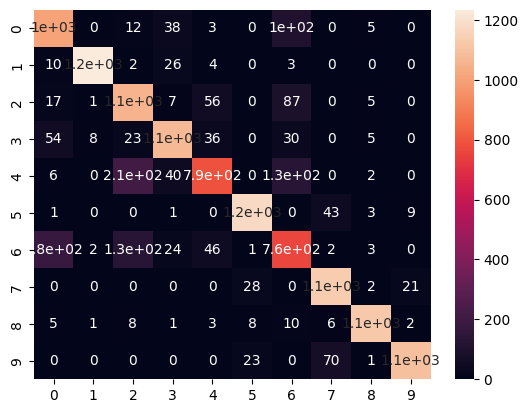

In [16]:
cm = confusion_matrix(val_y.numpy(), pred)

plt.figure()
sns.heatmap(cm,annot=True)

print("Accuracy:",accuracy_score(val_y.numpy(),pred)*100,"%")

tensor(1)


Text(0.5, 1.0, 'fm of layer2')

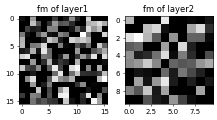

In [17]:
sp1 = val_x[0, :].reshape(1,-1)   # take one sample from validation set [1, 784]

res1 = predict(mlp,sp1,ret_fm=True)   # then make a prediction

print(val_y[0])  # true lable of the sample

plt.figure(figsize=(5, 3), dpi=50)
plt.subplot(121)
plt.imshow(res1[0].reshape(16, 16), cmap='gray')
plt.title("fm of layer1")
plt.subplot(122)
plt.imshow(res1[1].reshape(10, 10), cmap='gray')
plt.title("fm of layer2")

In [18]:
# begin testing
pred = predict(mlp, val_x, ret_fm=True)    # return (f1, f2, f3, y_preds)
pred[0].shape, pred[1].shape, pred[2].shape
pred_all = deepcopy(pred)

Each layer generates either of the two feature maps: 

1. **positive** feature map(on the correctly classified sample)
2. **negative** feature map(on the mis-classified sample)

i.e. for any class $c$ we have:
$$\bar x_{pos,c} = \frac{1}{M}\sum^{m}_{M}\sum_{k=0}^{K}x_{pos,c}^{(m)}$$
and
$$\bar x_{neg,c} = \frac{1}{M}\sum^{m}_{M}\sum_{k=0}^{K}x_{neg,c}^{(m)}$$

In [19]:
layer_num = len(pred) - 1

In [20]:
def get_benchmarks(val_y, pred, method=1):
    target = val_y.numpy()
    y_pred = pred[-1]

    if method == 1:

        benchmarks = dict()
        for l in range(layer_num):      # for all layers
            benchmarks[l] = {'pos':None, 'neg':None}     # feature map dict {layer0: {pos_dict, neg_dict}, layer1:{},,,}
            
            current_layer_fm = pred[l]                    # size: 12000*256
            pos_dict = dict()               # {'0': (numpy(1*256), t)}  t is the times '0' is visited
            neg_dict = dict()
            for i in range(current_layer_fm.shape[0]):    # for all samples
                if(y_pred[i] == target[i]):
                    if target[i] not in pos_dict:   # if the first time
                        pos_dict[target[i]] = (current_layer_fm[i], 1)
                    else:
                        t = pos_dict[target[i]][1]
                        pos_dict[target[i]] = (pos_dict[target[i]][0] * t + current_layer_fm[i]) / (t + 1)
                        pos_dict[target[i]][1] += 1
                else:
                    if target[i] not in neg_dict:
                        neg_dict[target[i]] = (current_layer_fm[i], 1)
                    else:
                        t = neg_dict[target[i]][1]
                        neg_dict[target[i]] = (neg_dict[target[i]][0] * t + current_layer_fm[i]) / (t + 1)
                        neg_dict[target[i]][1] += 1
            
            benchmarks[l]['pos'] = pos_dict
            benchmarks[l]['neg'] = neg_dict
        
        return benchmarks
    
    elif method == 2:

        # init dict
        d = dict()
        for l in range(layer_num):
            d[l] = {'pos': dict(), 'neg': dict()}
            for c in range(class_num):
                d[l]['pos'][c] = []
                d[l]['neg'][c] = []
        benchmarks = d.copy()

        # collecting
        for l in range(layer_num):
            current_layer_fm = pred[l]  # size: 12000*256
            for i in range(current_layer_fm.shape[0]):
                s = 'pos' if y_pred[i] == target[i] else 'neg'
                d[l][s][target[i]].append(current_layer_fm[i])
        
        # skip outliers
        for l in range(layer_num):
            for s in ['pos', 'neg']:
                for c in range(class_num):
                    fms = np.array(d[l][s][c])
                    benchmark = np.zeros((fms[0].shape))
                    
                    Z = 3
                    z = np.abs(stats.zscore(fms, axis=1))
                    z[np.where(z > Z)] = 0
                    for j in range(fms.shape[1]):
                        if np.count_nonzero(fms[:, j]) != 0:
                            benchmark[j] = np.sum(fms[:, j]) / np.count_nonzero(fms[:, j])  # calculate mean without outliers
                        else:
                            benchmark[j] = 0
                    benchmarks[l][s][c] = benchmark

        return benchmarks

In [21]:
"""
The function bhatta_dist() calculates the Bhattacharyya distance between two classes on a single feature.
    The distance is positively correlated to the class separation of this feature. Four different methods are
    provided for calculating the Bhattacharyya coefficient.

Created on 4/14/2018
Author: Eric Williamson (ericpaulwill@gmail.com)
https://github.com/EricPWilliamson/bhattacharyya-distance/blob/master/bhatta_dist.py
"""
def bhatta_dist(X1, X2):

    def get_density(x, cov_factor=0.1):
        density = gaussian_kde(x)
        density.covariance_factor = lambda:cov_factor
        density._compute_covariance()
        return density
    
    n_steps = max(X1.shape[1], X2.shape[1]) * 2

    d1 = get_density(X1)
    d2 = get_density(X2)

    cX = np.hstack((X1,X2))
    xs = np.linspace(np.min(cX),np.max(cX),n_steps)
    bht = 0

    for x in xs:
        p1 = d1(x)
        p2 = d2(x)
        bht += np.sqrt(p1*p2)*(np.max(cX)-np.min(cX))/n_steps
    
    return -np.log(bht) if bht != 0 else float('Inf')

In [22]:
def distance(benchmark, feature_map, method='L2', norm=True):
    """
    calculate the similarity between benchmark and a feature map
    """

    benchmark = benchmark.reshape(-1, 1)
    feature_map = feature_map.reshape(-1, 1)

    if norm is True:
        scaler = StandardScaler()
        benchmark = scaler.fit_transform(benchmark)
        feature_map = scaler.fit_transform(feature_map)

    if method == 'L2':
        return np.linalg.norm(benchmark - feature_map)
    if method == 'bha':
        return bhatta_dist(benchmark.reshape(1, -1), feature_map.reshape(1, -1))
    
    raise Exception("No designated method found.")

In [23]:
DISTANCE_METHOD = 'L2'
BENCHMARKS_METHOD = 2

In [24]:
benchmarks = get_benchmarks(val_y, pred, BENCHMARKS_METHOD)

class 0, layer 0, sim: 0.178660
class 0, layer 1, sim: 0.271330
class 0, layer 2, sim: 0.383076
class 1, layer 0, sim: 0.108407
class 1, layer 1, sim: 0.175649
class 1, layer 2, sim: 0.189780
class 2, layer 0, sim: 0.271084
class 2, layer 1, sim: 0.437106
class 2, layer 2, sim: 0.474560
class 3, layer 0, sim: 0.176709
class 3, layer 1, sim: 0.263979
class 3, layer 2, sim: 0.283160
class 4, layer 0, sim: 0.513515
class 4, layer 1, sim: 0.860109
class 4, layer 2, sim: 0.885751
class 5, layer 0, sim: 0.149768
class 5, layer 1, sim: 0.237975
class 5, layer 2, sim: 0.277139
class 6, layer 0, sim: 0.228017
class 6, layer 1, sim: 0.365166
class 6, layer 2, sim: 0.449314


<ipython-input-25-4b81a4042592>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(3, 1), dpi=50)


class 7, layer 0, sim: 0.147218
class 7, layer 1, sim: 0.306619
class 7, layer 2, sim: 0.401478
class 8, layer 0, sim: 0.180044
class 8, layer 1, sim: 0.259737
class 8, layer 2, sim: 0.244090
class 9, layer 0, sim: 0.173358
class 9, layer 1, sim: 0.418143
class 9, layer 2, sim: 0.581462


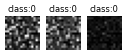

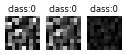

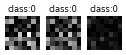

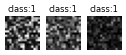

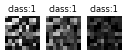

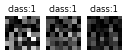

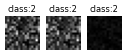

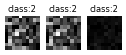

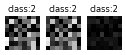

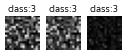

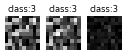

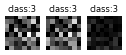

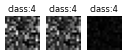

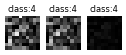

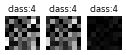

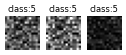

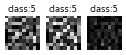

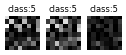

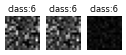

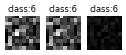

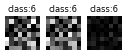

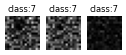

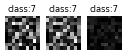

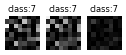

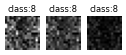

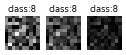

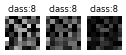

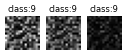

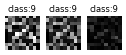

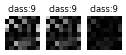

In [25]:
for c in range(class_num):
    for l in range(layer_num):
        fig = plt.figure(figsize=(3, 1), dpi=50)

        pos_bm = benchmarks[l]['pos'][c]
        neg_bm = benchmarks[l]['neg'][c]

        pos_bm = pos_bm.reshape(int(np.sqrt(len(pos_bm))), -1)
        neg_bm = neg_bm.reshape(int(np.sqrt(len(neg_bm))), -1)
        diff_bm = np.abs(np.subtract(pos_bm, neg_bm))

        imgs = [pos_bm, neg_bm, diff_bm]

        sim = 1 / distance(pos_bm, neg_bm, DISTANCE_METHOD)

        for i, img in enumerate(imgs):
            plt.subplot(1,3,i+1)
            plt.axis('off')
            plt.title('class:' + str(c))
            plt.imshow(img, cmap='gray')
            plt.clim(np.min(pos_bm), np.max(pos_bm))
        
        print('class %d, layer %d, sim: %f' % (c, l, sim))

In [26]:
np.array(pred[-1])

array([1, 9, 5, ..., 6, 8, 4])

In [27]:
val_y

tensor([1, 9, 5,  ..., 6, 8, 4])

- TODO: count similarities on all sample data, find a threshold

In [28]:
# init dict
sim_dict = dict()    # distribution dict
for l in range(layer_num):
    pos_dict = dict()
    neg_dict = dict()
    for c in range(class_num):
        pos_dict[c] = []
        neg_dict[c] = []
    sim_dict[l] = {'pos': pos_dict, 'neg': neg_dict}

for i in tqdm(range(val_x.shape[0])):
    pred = predict(mlp, val_x[i, :].reshape(1,-1), ret_fm=True)
    y_pred = pred[-1][0]
    target = int(val_y[i].numpy())

    for l in range(layer_num):  # compare on each layer
        bench_fm = benchmarks[l]['pos'][target]    # there're two benchmarks, only take positive one since it's meaningful
        fm = pred[l]

        sim = 1 / distance(bench_fm, fm, method=DISTANCE_METHOD)

        if y_pred == target:
            sim_dict[l]['pos'][target].append(sim)
        else:
            sim_dict[l]['neg'][target].append(sim)

100%|██████████| 12000/12000 [01:05<00:00, 183.56it/s]


100%|██████████| 10/10 [00:26<00:00,  2.63s/it]


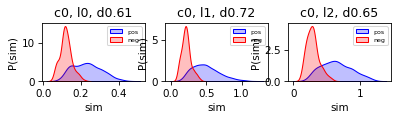

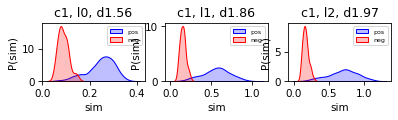

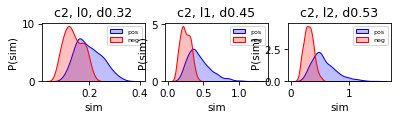

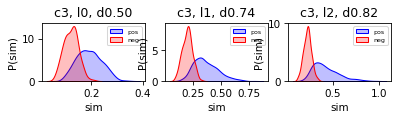

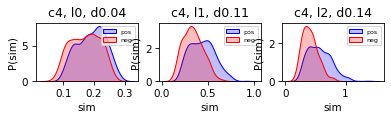

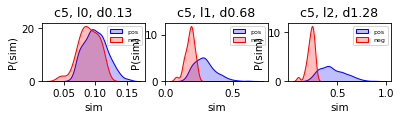

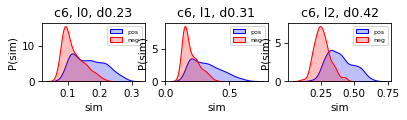

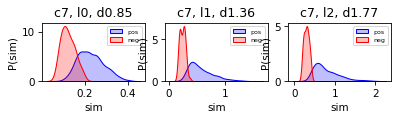

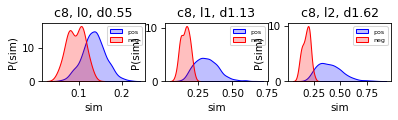

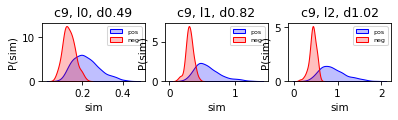

In [52]:
for c in tqdm(range(class_num)):
    fig = plt.figure(figsize=(6, 1), dpi=75)
    for l in range(layer_num):
        
        pos_data = sim_dict[l]['pos'][c]
        neg_data = sim_dict[l]['neg'][c]
        
        dis = bhatta_dist(np.array(pos_data).reshape(1, -1), np.array(neg_data).reshape(1, -1))

        plt.subplot(1, layer_num, l+1)
        ax = sns.kdeplot(pos_data, color="Blue", fill = True)
        ax = sns.kdeplot(neg_data, ax=ax, color="Red", fill= True)
        ax.legend(["pos","neg"],loc='upper right',prop={'size': 6})
        ax.set_ylabel('P(sim)')
        ax.set_xlabel('sim')
        ax.set_title('c%d, l%d, d%.2f' % (c, l, dis))

&emsp;&emsp; We can see from the kernel density distribution plots above that for most classes negative samples(red) are subjected to a different distribution from that of the positive samples. They tend to have a lower density.

&emsp;&emsp; Beware, if we change similarity metrics or normalization, the results might be different.

In [30]:
acc_dict = dict()
correct_list = [0] * class_num
counter_list = [0] * class_num
for i in range(len(val_y)):
    counter_list[val_y[i]] += 1
    if(int(val_y[i]) == pred_all[-1][i]):
        correct_list[val_y[i]] += 1

for i in range(class_num):
    acc_dict[i] = correct_list[i] / counter_list[i]
    print('class %d acc: %f' % (i, correct_list[i] / counter_list[i]))

class 0 acc: 0.861183
class 1 acc: 0.964816
class 2 acc: 0.859121
class 3 acc: 0.873068
class 4 acc: 0.665821
class 5 acc: 0.953696
class 6 acc: 0.658558
class 7 acc: 0.956816
class 8 acc: 0.962264
class 9 acc: 0.920742


# Sim method

In [31]:
rlb_dict = dict()
for l in range(layer_num):
    reliability = 0
    for c in range(class_num):
        pos_data = np.array(sim_dict[l]['pos'][c]).reshape(1, -1)
        neg_data = np.array(sim_dict[l]['neg'][c]).reshape(1, -1)
        bha = bhatta_dist(pos_data, neg_data)
        reliability += bha
    rlb_dict[l] = reliability

In [32]:
rlb_dict

{0: array([5.28038544]), 1: array([8.17577671]), 2: array([10.23131087])}

It can be seen **layer 3 has the largest distance**, indicating it seperates negative and positive samples well.

TODO: Get a Beyesian distribution curve for rolling dice

Decision boundary / bayes curve

1. bayes curve first

In [114]:
def sim2bayes(X1, X2):
    """
    X1: sims for positive samples, ndarray
    X2: sims for negative samples, ndarray
    """

    def PDF(x, X):
        return len(np.where(X < x)[0]) / X.shape[1]

    mx = max(np.max(X1), np.max(X2))
    mn = max(np.min(X1), np.min(X2))
    steps = max(X1.shape[1], X2.shape[1])

    P_y = X2.shape[1] / (X1.shape[1] + X2.shape[1])     # here is .shape[1], it's correct

    bayes_prob_dict = dict()
    for x in np.linspace(mn, mx, steps):    # sliding on x-axis
        PD1 = PDF(x, X2)    
        PD2 = PDF(x, np.hstack((X1, X2)))

        P_xIy = PD1
        P_x = PD2
        prob = P_xIy * P_y / P_x
        if(prob > 1.01):
            print(P_xIy, P_y, P_x, prob)
            raise Exception("Bayes probability is greater than 1!")

        bayes_prob_dict[x] = prob

    return bayes_prob_dict

In [115]:
sim_bayes_dict = dict() # bayes prob of how likely a sample with a similarity is negative
                        # note that it can not be called directly since the keys are continuous
for l in range(layer_num):
    sim_bayes_dict[l] = dict()
    for c in range(class_num):
        sim_bayes_dict[l][c] = None

for l in range(layer_num):
    for c in range(class_num):      
        pos_data = sim_dict[l]['pos'][c]
        neg_data = sim_dict[l]['neg'][c]
        d = sim2bayes(np.array(pos_data).reshape(1, -1), np.array(neg_data).reshape(1, -1))
        sim_bayes_dict[l][c] = d

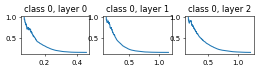

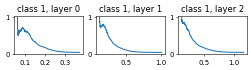

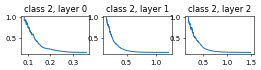

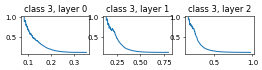

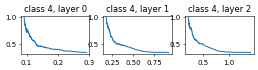

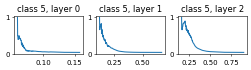

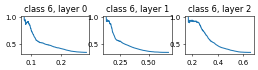

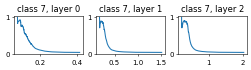

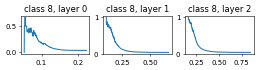

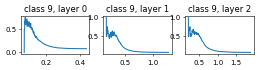

In [120]:
for c in range(class_num): 
    fig = plt.figure(figsize=(6, 1), dpi=50)
    for l in range(layer_num):
        plt.subplot(1, 3, l + 1)
        plt.plot(list(sim_bayes_dict[l][c].keys()), list(sim_bayes_dict[l][c].values()))
        plt.title("class %d, layer %d" % (c, l))

With these Bayes probabilities, we can change previous strategy used in Trace method. This time we don't just roll the dice and let trace method's bayes probability makes classification. Instead, for each sample, we detect its trace, and it's corresponding tricky probability based on its sim value(given by 1/L2 distance), after all we roll the dice and report it's a tricky sample.

# Trace method

Note: Take out those neg samples with large sim -> how are they classified to pos sample?

Note: take 1 neg with very large sim and 1 pos

4 kinds of images: pos+sim, pos-sim, neg+sim, neg-sim

find 5 pics for each

In [122]:
obs_l = 0   # layer in observance
obs_c = 6   # class in observance

Q1_pos = np.quantile(sim_dict[obs_l]['pos'][obs_c], 0.25)
Q3_pos = np.quantile(sim_dict[obs_l]['pos'][obs_c], 0.75)
Q1_neg = np.quantile(sim_dict[obs_l]['neg'][obs_c], 0.25)
Q3_neg = np.quantile(sim_dict[obs_l]['neg'][obs_c], 0.75)

imobs_dict = {'pos_Q1': [], 'pos_Q3': [], 'neg_Q1': [], 'neg_Q3': []}
for i in range(val_x.shape[0]):
    if(int(val_y[i]) == obs_c):     # only class in observance will be picked up       
        pred = predict(mlp, val_x[i, :].reshape(1,-1), ret_fm=True)

        y_pred = pred[-1][0]
        target = obs_c

        fm = pred[obs_l]
        benchmark = benchmarks[obs_l]['pos'][obs_c]
        sim = 1 / distance(benchmark, fm)

        if(y_pred == target):   # pos
            if(sim < Q1_pos and len(imobs_dict['pos_Q1']) < 5):
                imobs_dict['pos_Q1'].append(i)  # put index
            elif(sim > Q3_pos and len(imobs_dict['pos_Q3']) < 5):
                imobs_dict['pos_Q3'].append(i)
        else:
            if(sim < Q1_neg and len(imobs_dict['neg_Q1']) < 5):
                imobs_dict['neg_Q1'].append(i)  # put index
            elif(sim > Q3_neg and len(imobs_dict['neg_Q3']) < 5):
                imobs_dict['neg_Q3'].append(i)
        
        # found 5 imgs for 4 types, exit
        if(len(imobs_dict['pos_Q1']) == 5 and len(imobs_dict['pos_Q3']) == 5 and 
           len(imobs_dict['neg_Q1']) == 5 and len(imobs_dict['neg_Q3']) == 5):
           break

if(len(imobs_dict['pos_Q1']) != 5 or len(imobs_dict['pos_Q3']) != 5 or 
   len(imobs_dict['neg_Q1']) != 5 or len(imobs_dict['neg_Q3']) != 5):
   raise  Exception("Fetch images failed.")

The first row are the images that are classified correctly but have a low similarity with the benchmark of the class.

The second row are the images classified correctly whose similarity is higher than 75% of total samples.

The third row images are misclassified and has a low similarity to benchmark.

The forth row images are misclassified but has a high similarity to benchmark.

The 2nd row looks really eriee... how are these clothes shirts??? They could look like anything(e.g. shirt, coat...) but shirts. NO wonders the network can not gain a high acc..

class 6: Shirt, layer 0


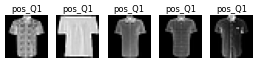

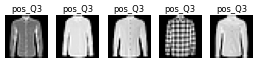

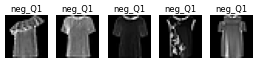

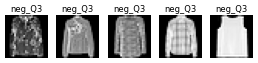

In [123]:
print('class %d: %s, layer %d' % (obs_c, label_dict[obs_c], obs_l))
for key in list(imobs_dict.keys()):
    fig = plt.figure(dpi=50)
    for i, index in enumerate(imobs_dict[key]):
        img = val_x[index].reshape(int(np.sqrt(len(val_x[index]))), -1)
        plt.subplot(1,5,i+1)
        plt.axis('off')
        plt.imshow(img, cmap='gray')
        plt.title(key)

In [178]:
def get_trace(x, benchmarks, rt_sim=False, prt=False):
    """
    x: a sample, input image
    """
    pred = predict(mlp, x, True)
    if(prt): print("pred label: " + str(pred[-1][0]))

    traces_ls = []
    sims_ls = []
    for l in range(layer_num):
        fm = pred[l]                    # feature map on current layer
        bms = [benchmarks[l]['pos'][i] for i in range(len(benchmarks[l]['pos']))]
        sims = [1 / distance(bm, fm, 'L2') for bm in bms]
        traces_ls.append(np.argmax(sims))
        if(rt_sim): sims_ls.append(np.max(sims))
        if(prt): print(sims)
    
    ret = traces_ls if rt_sim is False else traces_ls, sims_ls

    return ret

In [183]:
def get_trace2(x, benchmarks, rt_sim=False, prt=False):
    """
    x: a sample, input image
    """
    pred = predict(mlp, x, True)
    if(prt): print("pred label: " + str(pred[-1][0]))

    traces_ls = []
    sims_ls = []
    for l in range(layer_num):
        sims = []
        for c in range(class_num):
            sim = 1 / distance(benchmarks[l]['pos'][c], pred[l], 'L2')
            sims.append(sim)
        traces_ls.append(np.argmax(sims))
        if(rt_sim): sims_ls.append(np.max(sims))
        if(prt): print(sims)
    
    ret = traces_ls if rt_sim is False else traces_ls, sims_ls

    return ret

In [125]:
imobs_dict['pos_Q1'], imobs_dict['pos_Q3'], imobs_dict['neg_Q1'], imobs_dict['neg_Q3']

([32, 36, 43, 141, 209],
 [47, 60, 103, 130, 302],
 [11, 139, 993, 1036, 1216],
 [87, 751, 991, 1014, 1439])

In [126]:
OBS_INDEX = 61

In [127]:
get_trace(val_x[OBS_INDEX, :].reshape(1,-1), benchmarks, prt=True)

pred label: 5
[0.04304989745802578, 0.040319442199073886, 0.04525867331934894, 0.04262418633949655, 0.044300586755387214, 0.09362634220069248, 0.04541819260014467, 0.06112248271625591, 0.05557627735231995, 0.07938859386931883]
[0.06795239597825536, 0.06375063906882793, 0.0740909619996165, 0.0692058224107661, 0.07075104185479333, 0.3097797437515312, 0.07333467515779357, 0.12591915086706418, 0.09454807393855084, 0.14628493185378455]
[0.08860049217890124, 0.07940547476670365, 0.0949823695433689, 0.0872620782401095, 0.08954968097159943, 0.6268468147317818, 0.09538913224506704, 0.1616210635484083, 0.11769701761222075, 0.17037554082026166]


[5, 5, 5]

0.06360969368185797


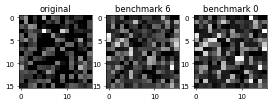

In [128]:
plt.figure(dpi=50)

plt.subplot(1,3,1)
plt.title('original')
plt.imshow(predict(mlp, val_x[OBS_INDEX, :].reshape(1,-1), True)[0].reshape(16, 16), cmap='gray')

plt.subplot(1,3,2)
plt.title('benchmark 6')
plt.imshow(benchmarks[0]['pos'][6].reshape(16, 16), cmap='gray')

plt.subplot(1,3,3)
plt.title('benchmark 0')
plt.imshow(benchmarks[0]['pos'][0].reshape(16, 16), cmap='gray')

print(1 / np.linalg.norm(benchmarks[0]['pos'][6] - predict(mlp, val_x[68, :].reshape(1,-1), True)[0]))

Note: improve similarity function and benchmark generation

TODO: Reliability Analysis. Counting the pos and neg trace

In [129]:
# init dict
trace_dict = dict()
for c in range(class_num):
    trace_dict[c] = {'pos': [], 'neg': []}

for i in tqdm(range(val_x.shape[0])): 
    val_x_tmp = val_x[i, :].reshape(1,-1)

    tc = get_trace(val_x_tmp, benchmarks) # get trace

    pred = predict(mlp, val_x_tmp, True)
    y_pred = pred[-1][0]
    target = int(val_y[i])
    
    if(y_pred == target):
        trace_dict[target]['pos'].append(tc)
    else:
        trace_dict[target]['neg'].append(tc)

100%|██████████| 12000/12000 [09:32<00:00, 20.97it/s]


class 0 layer 0, reliability: 0.939303
class 0 layer 1, reliability: 0.965174
class 0 layer 2, reliability: 0.976119
class 1 layer 0, reliability: 0.977310
class 1 layer 1, reliability: 0.986224
class 1 layer 2, reliability: 0.989465
class 2 layer 0, reliability: 0.800000
class 2 layer 1, reliability: 0.899526
class 2 layer 2, reliability: 0.926066
class 3 layer 0, reliability: 0.980429
class 3 layer 1, reliability: 0.986952
class 3 layer 2, reliability: 0.964585
class 4 layer 0, reliability: 0.805591
class 4 layer 1, reliability: 0.946633
class 4 layer 2, reliability: 0.982211
class 5 layer 0, reliability: 0.387564
class 5 layer 1, reliability: 0.887564
class 5 layer 2, reliability: 0.946337
class 6 layer 0, reliability: 0.550132
class 6 layer 1, reliability: 0.680739
class 6 layer 2, reliability: 0.763852
class 7 layer 0, reliability: 0.965487
class 7 layer 1, reliability: 0.977876
class 7 layer 2, reliability: 0.968142
class 8 layer 0, reliability: 0.959893
class 8 layer 1, reliabil

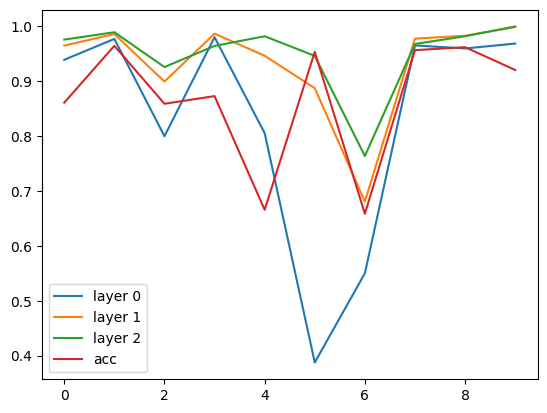

In [130]:
rlb_dict = dict()

acc_list = [correct_list[i] / counter_list[i] for i in range(class_num)]

for l in range(layer_num):
    rlb_dict[l] = []

for c in range(class_num):
    trace_pos = np.array(trace_dict[c]['pos'])
    trace_neg = np.array(trace_dict[c]['neg'])

    for l in range(layer_num):

        reliability = np.mean(np.array(trace_dict[c]['pos'])[:, l] == c)

        rlb_dict[l].append(reliability)  # haven't considered the weights from sample size yet

        print("class %d layer %d, reliability: %f" % (c, l, reliability))

plt.figure()
for l in range(layer_num):
    print("layer %d reliability: %f" % (l, np.sum(rlb_dict[l])))
    plt.plot(rlb_dict[l], label='layer '+str(l))
plt.plot(acc_list, label='acc')
plt.legend()

The reliability here indicates that, take class `0` for instance, `93.6979%` positive samples is predicted as '0' by the first layer. Likewise, `95.4588%` positive samples is predicted to be '0' on the second layer.

Note: Why the reliability of class 9 is so low but the acc is so high? Assumption: the similarity still needs improvement.

Layer 1 has the greatest reliability. So it's selected as the **Judge Layer**
- Question: can we take different layers so that at anytime the best reliability can be acchieved? 
- A: No, test sets are always unknown. But we can prefer a 'global' layer or 'problem-oriented' layer.

Before moving on, we can attempt to illustrate traces.

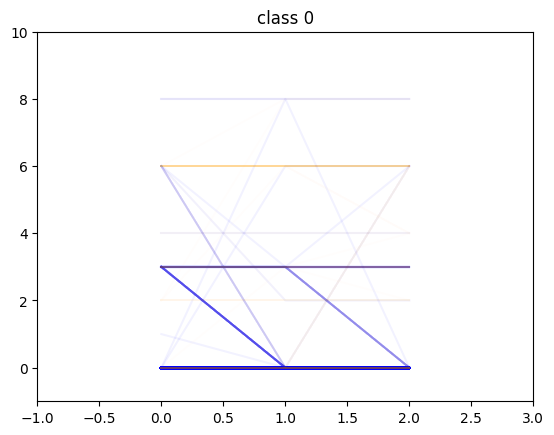

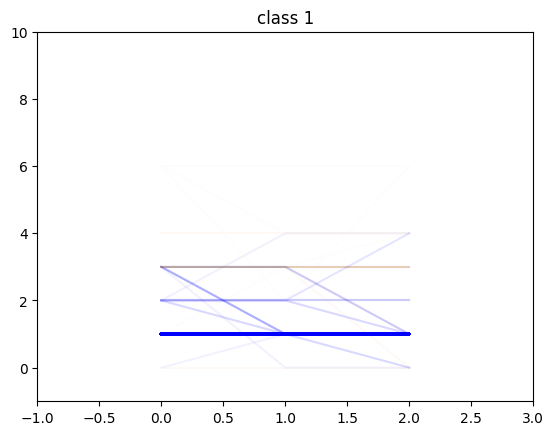

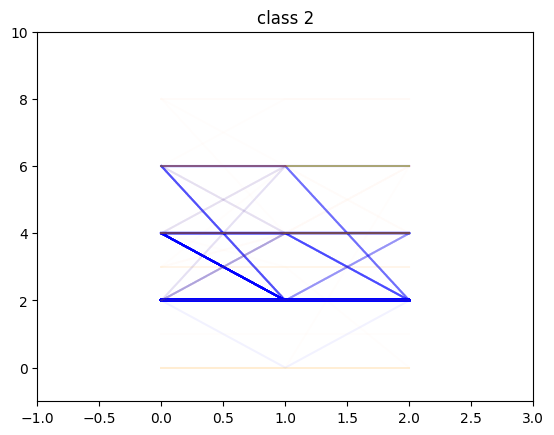

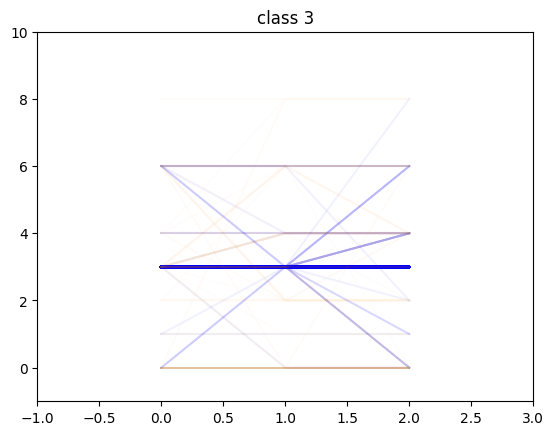

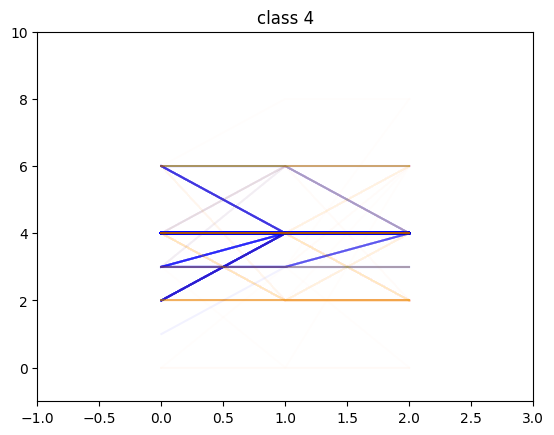

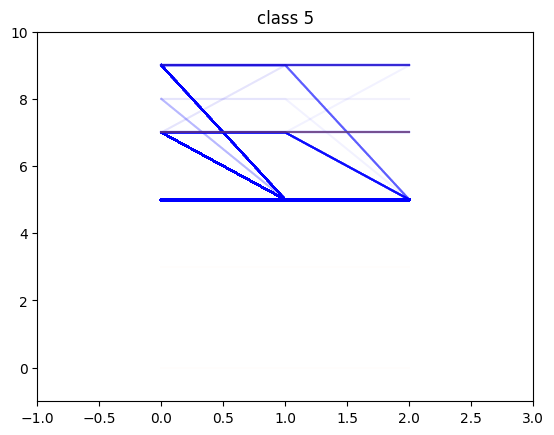

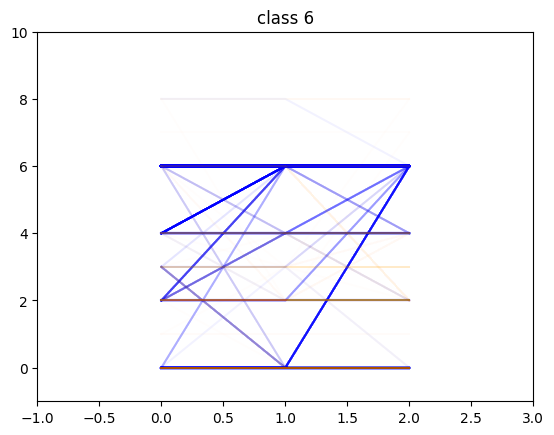

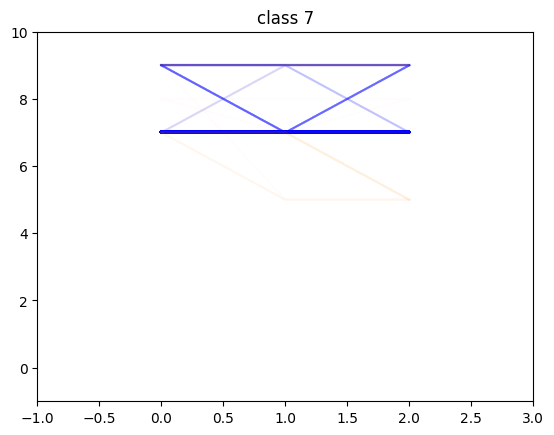

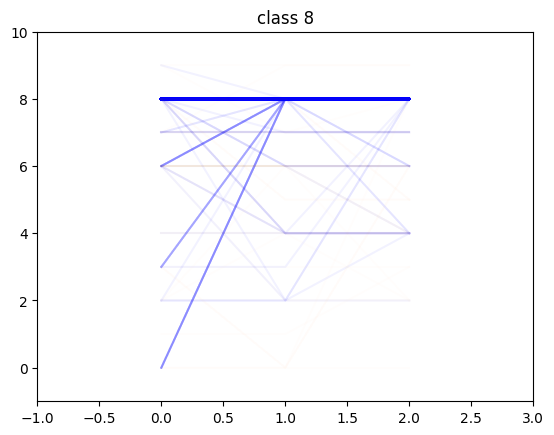

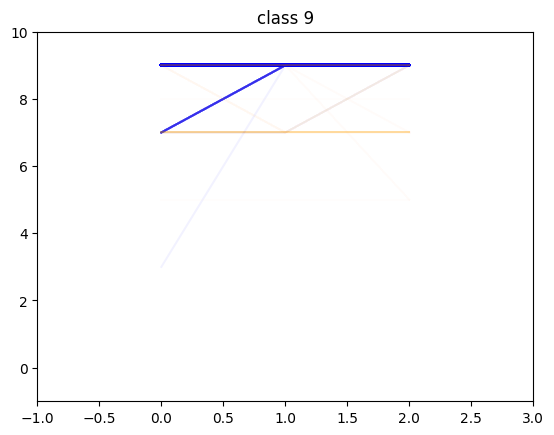

In [131]:
for c in range(class_num):
    fig = plt.figure(dpi=50)
    plt.title('class %d' % c)

    trace_pos = np.array(trace_dict[c]['pos'])
    trace_neg = np.array(trace_dict[c]['neg'])

    cl = ["blue", "orange"]
    alphas = [0.05, 0.01]
    for i, tcs in enumerate([trace_pos, trace_neg]):
        for tc in tcs:
            plt.plot(tc, color=cl[i], alpha=alphas[i])
            plt.xlim([-1, layer_num])
            plt.ylim([-1, class_num])

**What are we gonna do with the "Judge Layer"?**

One of the most intuitive methods is "What-I-Say-Goes".

But seperate judge layers is not accurate enough. We can combine multiple judge layers into the <mark>Jury</mark>

TODO: Count the top-k frequent traces for each class and represent them as decisive traces.

In [132]:
def list2str(ls):
    s = ""
    for item in ls: s += str(item) + '-'
    return s[:-1]

In [133]:
def find_top_K_traces(traces, K):

    # counting frequency
    size = [class_num] * layer_num
    cube = np.zeros(size)   # index is trace state
    for tc in traces:
        cube[tuple(tc)] += 1    

    c_d = dict()    # cube dict, key is frequency, value is index(state)
    for i in range(class_num):
        for j in range(class_num):
            for k in range(class_num):
                if(cube[i][j][k] != 0):
                    c_d[cube[i][j][k]] = list2str([i, j, k])

    # sorting by key(frequency)
    od = OrderedDict(sorted(c_d.items(), reverse=True))

    # keep top K traces, actual traces number <= K
    ret = []
    cnt = 0
    for k, v in od.items():
        if cnt < K:
            ret.append([v, k])
            cnt += 1
        else: break
    
    return ret

In [134]:
K = 5

In [135]:
tptl = []     # top positve traces list
for c in range(class_num):
    trace_pos = np.array(trace_dict[c]['pos'])
    t = find_top_K_traces(trace_pos, K)
    tptl.append(t)
    print("class %d: " % c)
    print(t)

class 0: 
[['0-0-0', 941.0], ['3-0-0', 23.0], ['3-3-3', 17.0], ['3-3-0', 11.0], ['6-0-0', 4.0]]
class 1: 
[['1-1-1', 1205.0], ['3-1-1', 6.0], ['3-3-1', 4.0], ['2-2-1', 3.0], ['3-3-3', 2.0]]
class 2: 
[['2-2-2', 828.0], ['4-2-2', 90.0], ['4-4-4', 52.0], ['6-2-2', 21.0], ['6-6-2', 12.0]]
class 3: 
[['3-3-3', 1028.0], ['3-3-4', 7.0], ['3-3-6', 5.0], ['6-6-6', 4.0], ['4-4-4', 3.0]]
class 4: 
[['4-4-4', 632.0], ['2-4-4', 50.0], ['3-4-4', 32.0], ['6-4-4', 31.0], ['3-3-4', 18.0]]
class 5: 
[['5-5-5', 455.0], ['7-5-5', 418.0], ['9-5-5', 163.0], ['7-7-5', 50.0], ['9-9-9', 37.0]]
class 6: 
[['6-6-6', 399.0], ['0-0-0', 103.0], ['4-6-6', 74.0], ['0-0-6', 39.0], ['2-6-6', 25.0]]
class 7: 
[['7-7-7', 1073.0], ['9-9-9', 17.0], ['9-7-7', 16.0], ['7-7-9', 15.0], ['9-9-7', 5.0]]
class 8: 
[['8-8-8', 1067.0], ['0-8-8', 11.0], ['6-8-8', 8.0], ['7-7-7', 3.0], ['8-8-4', 2.0]]
class 9: 
[['9-9-9', 1058.0], ['7-9-9', 32.0], ['7-7-9', 1.0]]


In [136]:
tntl = []     # top negative traces list
for c in range(class_num):
    trace_neg = np.array(trace_dict[c]['neg'])
    t = find_top_K_traces(trace_neg, K)
    tntl.append(t)
    print("class %d: " % c)
    print(t)

class 0: 
[['0-0-0', 55.0], ['6-6-6', 35.0], ['3-3-3', 31.0], ['3-0-0', 7.0], ['3-3-0', 6.0]]
class 1: 
[['3-3-3', 24.0], ['4-4-4', 3.0], ['3-3-1', 2.0], ['6-6-6', 1.0]]
class 2: 
[['4-4-4', 55.0], ['6-6-6', 43.0], ['0-0-0', 14.0], ['2-4-4', 11.0], ['2-2-2', 7.0]]
class 3: 
[['0-0-0', 35.0], ['3-3-3', 17.0], ['6-6-6', 14.0], ['4-4-4', 8.0], ['6-2-2', 5.0]]
class 4: 
[['4-4-4', 125.0], ['2-2-2', 57.0], ['6-6-6', 43.0], ['3-3-3', 26.0], ['4-2-2', 20.0]]
class 5: 
[['7-7-7', 40.0], ['9-9-9', 13.0], ['8-8-8', 1.0]]
class 6: 
[['0-0-0', 159.0], ['2-2-2', 84.0], ['4-4-4', 39.0], ['3-3-3', 17.0], ['3-0-0', 14.0]]
class 7: 
[['9-9-9', 20.0], ['7-7-5', 12.0], ['7-7-7', 7.0], ['7-5-5', 6.0], ['7-9-9', 3.0]]
class 8: 
[['6-6-6', 8.0], ['7-7-7', 4.0], ['8-8-8', 3.0], ['8-8-5', 2.0], ['9-9-9', 1.0]]
class 9: 
[['9-9-9', 37.0], ['7-7-7', 30.0], ['7-7-9', 9.0], ['7-9-9', 7.0], ['9-7-7', 5.0]]


1. Pos from different class might have same trace
2. Neg might have same trace with Pos

- Pos from different class might have same trace
    - it doesn't matter, we're just picking tricky samples.
- Neg might have same trace with Pos
    - use probability?
    - find unique trace that exclusively belongs to neg?

TODO: exclusive trace + probability

In [137]:
def get_traces_dict(ttl):
    """
    re-organize top k traces into dict for easy look-up
    if don't understand how it's done, print out ttl
    """
    traces = dict()
    for tt in ttl:
        for t in tt: # single trace
            traces[t[0]] = t[1] if t[0] not in traces else traces[t[0]] + t[1]
    return traces

In [138]:
traces_pos_dict = get_traces_dict(tptl)
traces_neg_dict = get_traces_dict(tntl)

In [139]:
def find_exclusive_negative_traces(tptl, tntl):

    def extract_traces(ttl): # ttl: either tptl or tntl
        traces = []
        for tt in ttl:
            for t in tt: # single trace
                traces.append(t[0])
        return traces

    traces_pos = extract_traces(tptl)
    traces_neg = extract_traces(tntl)

    traces_pos = set(traces_pos)
    traces_neg = set(traces_neg)

    diff = traces_neg - traces_pos  # traces only belongs to diff

    return diff

In [140]:
ent = find_exclusive_negative_traces(tptl, tntl) # exclusive negative traces

for trace in ent:
    print("negative trace %s appears %d times" % (trace, traces_neg_dict[trace]))

negative trace 8-8-5 appears 2 times


There are few exclusive traces only belong to negative samples, so this method doesn't work effectivly.

We put our hope on probabilistic method. Specifically, Bayes method.

$$P(y|x)=\frac{P(x|y)P(y)}{P(x)}$$

Imagine we have a trace '0-0-0', which appears the most for class 0, but can also be obtained on other classes, even on negative samples. We have priori $P(x, y)$ where $x$ is trace and $y$ is class. We use Bayesian method to find out $P(y|x)$, the likelihood one trace appears to be negative when given $x$.

TODO: Bayesian method

Let's do experiment first.

In [141]:
tt = tptl[0] + tntl[0]
tt

[['0-0-0', 941.0],
 ['3-0-0', 23.0],
 ['3-3-3', 17.0],
 ['3-3-0', 11.0],
 ['6-0-0', 4.0],
 ['0-0-0', 55.0],
 ['6-6-6', 35.0],
 ['3-3-3', 31.0],
 ['3-0-0', 7.0],
 ['3-3-0', 6.0]]

In [142]:
def merge_ttl2dict(tptl, tntl):
    ls = list()
    for i in range(len(tptl)):
        ls.append(tptl[i] + tntl[i])
    
    merged = dict()
    for i, tt in enumerate(ls):
        d = dict()
        for t in tt:
            if t[0] not in d: d[t[0]] = t[1]
            else: d[t[0]] += t[1]
        merged[i] = d
    
    return merged

In [143]:
t_d = merge_ttl2dict(tptl, tntl)  # traces dict merged
t_d

{0: {'0-0-0': 996.0,
  '3-0-0': 30.0,
  '3-3-3': 48.0,
  '3-3-0': 17.0,
  '6-0-0': 4.0,
  '6-6-6': 35.0},
 1: {'1-1-1': 1205.0,
  '3-1-1': 6.0,
  '3-3-1': 6.0,
  '2-2-1': 3.0,
  '3-3-3': 26.0,
  '4-4-4': 3.0,
  '6-6-6': 1.0},
 2: {'2-2-2': 835.0,
  '4-2-2': 90.0,
  '4-4-4': 107.0,
  '6-2-2': 21.0,
  '6-6-2': 12.0,
  '6-6-6': 43.0,
  '0-0-0': 14.0,
  '2-4-4': 11.0},
 3: {'3-3-3': 1045.0,
  '3-3-4': 7.0,
  '3-3-6': 5.0,
  '6-6-6': 18.0,
  '4-4-4': 11.0,
  '0-0-0': 35.0,
  '6-2-2': 5.0},
 4: {'4-4-4': 757.0,
  '2-4-4': 50.0,
  '3-4-4': 32.0,
  '6-4-4': 31.0,
  '3-3-4': 18.0,
  '2-2-2': 57.0,
  '6-6-6': 43.0,
  '3-3-3': 26.0,
  '4-2-2': 20.0},
 5: {'5-5-5': 455.0,
  '7-5-5': 418.0,
  '9-5-5': 163.0,
  '7-7-5': 50.0,
  '9-9-9': 50.0,
  '7-7-7': 40.0,
  '8-8-8': 1.0},
 6: {'6-6-6': 399.0,
  '0-0-0': 262.0,
  '4-6-6': 74.0,
  '0-0-6': 39.0,
  '2-6-6': 25.0,
  '2-2-2': 84.0,
  '4-4-4': 39.0,
  '3-3-3': 17.0,
  '3-0-0': 14.0},
 7: {'7-7-7': 1080.0,
  '9-9-9': 37.0,
  '9-7-7': 16.0,
  '7-7-9': 1

In [144]:
P_xIy = t_d[4]['4-4-4'] / np.sum(list(t_d[4].values()))    # take I as '|', use your pictogramic imagination :)
print('P(x|y): ', P_xIy)

sum = 0
for c in range(class_num):
    sum += np.sum(list(t_d[c].values()))

P_y = np.sum(list(t_d[4].values())) / sum
print('P(y): ', P_y)

sum1 = 0
for c in range(class_num):
    sum1 += 0 if '4-4-4' not in t_d[c] else t_d[c]['4-4-4']

P_x = sum1 / sum
print('P(x): ', P_x)

P(x|y):  0.7321083172147002
P(y):  0.09178872614292055
P(x):  0.08140257434531735


Bayes Rules:

$$P(y|x)=\frac{P(x|y)P(y)}{P(x)}$$

In [145]:
P_yIx = P_xIy * P_y / P_x
P_yIx

0.8255179934569247

If we have a trace `4-4-4`, which is given by the jury, it is of 79.7% probability a class 4 sample. 

We notice that class 6 also has a `4-4-4` trace, we can encapsulate the function and do the same thing for class 6.

In [146]:
def bayes_prob(t_d, c, trace):
    P_xIy = t_d[c][trace] / np.sum(list(t_d[c].values()))    # take I as '|', use your pictogramic imagination :)

    sum = 0
    for cls in range(class_num):
        sum += np.sum(list(t_d[cls].values()))

    P_y = np.sum(list(t_d[c].values())) / sum

    sum1 = 0
    for cls in range(class_num):
        sum1 += 0 if trace not in t_d[cls] else t_d[cls][trace]

    P_x = sum1 / sum

    P_yIx = P_xIy * P_y / P_x
    
    return P_yIx

In [147]:
bayes_prob(t_d, 6, '4-4-4')

0.0425299890948746

It is of 7.16% probability to have a '4-4-4' trace from class 6. 

We'll roll a dice and decide which class a trace belongs to, and terminate inference.

Question: **Do we have to roll the dice and stop inference? It's dictatorship :(**

In [148]:
trace_list = []
for cls in t_d.keys():
    t_d_tmp = t_d[cls]
    for trace in t_d_tmp.keys():
        trace_list.append(str(trace))

trace_set = set(trace_list)

bayes_dict = dict()
for trace in trace_set:
    d = dict()
    for c in range(class_num):
        if trace in t_d[c]:     # if trace is in current class
            prob = bayes_prob(t_d, c, trace)
            d[c] = prob
    bayes_dict[trace] = d

bayes_dict

{'9-9-9': {5: 0.04226542688081149,
  7: 0.0312764158918005,
  8: 0.00084530853761623,
  9: 0.9256128486897718},
 '7-7-9': {7: 0.5999999999999999, 9: 0.3999999999999999},
 '2-6-6': {6: 1.0},
 '3-3-1': {1: 1.0},
 '2-2-2': {2: 0.855532786885246,
  4: 0.058401639344262304,
  6: 0.08606557377049182},
 '6-6-2': {2: 1.0000000000000002},
 '7-7-5': {5: 0.8064516129032256, 7: 0.1935483870967742},
 '0-0-6': {6: 1.0000000000000002},
 '6-6-6': {0: 0.06398537477148081,
  1: 0.0018281535648994518,
  2: 0.07861060329067643,
  3: 0.03290676416819013,
  4: 0.07861060329067641,
  6: 0.7294332723948812,
  8: 0.014625228519195614},
 '3-3-6': {3: 1.0},
 '6-4-4': {4: 1.0},
 '6-8-8': {8: 1.0},
 '1-1-1': {1: 1.0},
 '3-3-4': {3: 0.27999999999999997, 4: 0.72},
 '7-5-5': {5: 0.9858490566037734, 7: 0.014150943396226415},
 '2-4-4': {2: 0.18032786885245902, 4: 0.819672131147541},
 '7-9-9': {7: 0.07142857142857142, 9: 0.9285714285714285},
 '9-5-5': {5: 1.0},
 '6-2-2': {2: 0.8076923076923077, 3: 0.19230769230769232},


In [149]:
def roll_dice(bayes_dict, trace):
    dice = random.random()
    d = bayes_dict[trace]

    sum = 0
    ret = 0
    for key in d.keys():
        sum += d[key]
        if dice < sum:
            ret = int(key)
            break
    
    return ret

Now it's time for fruit.

In [182]:
# Prevent repetitive tasks
trace_ls = []
sims_ls = []
for i in tqdm(range(val_x.shape[0])):
    x = val_x[i, :].reshape(1,-1)
    trace, sims = get_trace(x, benchmarks, rt_sim=True)
    trace_ls.append(trace)
    sims_ls.append(sims)

100%|██████████| 12000/12000 [08:20<00:00, 23.98it/s]


In [184]:
preds = []
preds_jury = []
for i in tqdm(range(val_x.shape[0])):
        x = val_x[i, :].reshape(1,-1)
        pred = predict(mlp, x)[0]
        preds.append(pred)

        trace = trace_ls[i]
        trace = list2str(trace)
        
        pred_jury = roll_dice(bayes_dict, trace) if trace in bayes_dict else pred
        preds_jury.append(pred_jury)

100%|██████████| 12000/12000 [00:03<00:00, 3000.94it/s]


TODO: Calculate a mutation rate

In [185]:
preds_jury = np.array(preds_jury)
preds = np.array(preds)

In [186]:
mutation_rate = 1 - np.mean(preds_jury == preds)
mutation_rate 

0.15008333333333335

Accuracy: 86.91666666666666 %


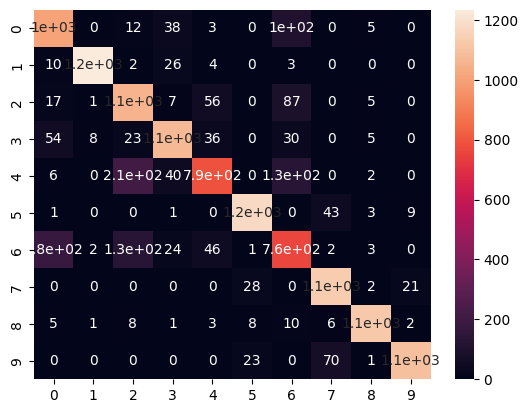

In [200]:
preds = predict(mlp,val_x)
cm = confusion_matrix(val_y.numpy(), preds)

plt.figure()
sns.heatmap(cm,annot=True)

print("Accuracy:",accuracy_score(val_y.numpy(),preds)*100,"%")

Accuracy: 79.83333333333333 %


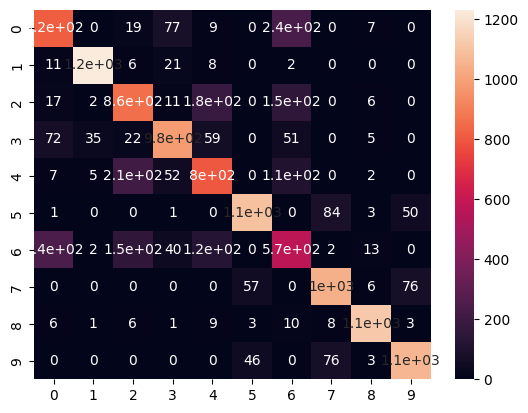

In [188]:
cm = confusion_matrix(val_y.numpy(), preds_jury)

plt.figure()
sns.heatmap(cm,annot=True)

print("Accuracy:",accuracy_score(val_y.numpy(),preds_jury)*100,"%")

Yayk!

29 March:

Let's find out why the accuracy goes down.

First, let's look at how each class changes.

In [189]:
acc_jury_dict = dict()
correct_list = [0] * class_num
counter_list = [0] * class_num
for i in range(len(val_y)):
    counter_list[val_y[i]] += 1
    if(int(val_y[i]) == preds_jury[i]):
        correct_list[val_y[i]] += 1

for c in range(class_num):
    acc_jury_dict[c] = correct_list[c] / counter_list[c]
    print('class %d acc: %f, change: %f' % (c, correct_list[c] / counter_list[c], acc_jury_dict[c] - acc_dict[c]))

class 0 acc: 0.700086, change: -0.161097
class 1 acc: 0.962471, change: -0.002346
class 2 acc: 0.698697, change: -0.160423
class 3 acc: 0.801465, change: -0.071603
class 4 acc: 0.677665, change: 0.011844
class 5 acc: 0.887084, change: -0.066613
class 6 acc: 0.498697, change: -0.159861
class 7 acc: 0.882303, change: -0.074513
class 8 acc: 0.959691, change: -0.002573
class 9 acc: 0.894604, change: -0.026138


Experiments prove that a larger K can't improve accuracy affectively, but a minor improvement can be seen.

....
Don't know what to do..

Give up trace method, go back to sim.

I'm back again.

Apparently rolling dice with trace bayes probability is not a good idea.  Now we turn to similarity probability. Presumably we are not just rolling dice with similarity bayes probability, by this I mean, once we gain a trace for a sample during jury layers, we analyse it's similarity with benchmark indicated by trace. If the similarities with all benchmarks(layer0, l1, l2) are low, a sample is more likely to be a tricky sample and to be reported.

Notice that trace might not be necessarily accurate. This risks leading to a bad ending.

In [192]:
def get_bayes_from_sim_dict(sim_bayes_dict, layer, state, sim):
    d = sim_bayes_dict[layer][state]
    d_keys = list(d.keys())
    for key in d_keys:
        if key > sim:
            break
    return sim_bayes_dict[layer][state][key]

In [226]:
tricky_idx = []
for i in tqdm(range(val_x.shape[0])):
    sims = sims_ls[i]
    trace = trace_ls[i]
    probs = []
    for l in range(len(sims)):
        bayes_prob = get_bayes_from_sim_dict(sim_bayes_dict, l, trace[l], sims[l])
        probs.append(bayes_prob)
    
    prob = np.prod(probs)   # take multiplication of all data as final probability

    # roll god's dice
    dice = random.random()
    if(dice < prob): tricky_idx.append(i)

100%|██████████| 12000/12000 [00:04<00:00, 2592.04it/s]


In [227]:
len(tricky_idx)

592

 there are 592 samples reported as tricky ones

In [228]:
val_x_tricky = val_x[tricky_idx]
val_y_tricky = val_y.numpy()[tricky_idx]
preds = np.array(predict(mlp,val_x))
pred_y_tricky = preds[tricky_idx]

print("Accuracy:",accuracy_score(val_y_tricky, pred_y_tricky)*100,"%")

Accuracy: 68.07432432432432 %


The network performs worse than usual on tricky dataset picked by the jury layers. This is exactly what we want.

In [229]:
val_x_debugged = np.delete(val_x, tricky_idx, axis=0)
val_y_debugged = np.delete(val_y.numpy(), tricky_idx, axis=0)
preds = np.array(predict(mlp,val_x))
pred_y_debugged = np.delete(preds, tricky_idx, axis=0)

print("Accuracy:",accuracy_score(val_y_debugged, pred_y_debugged)*100,"%")

Accuracy: 87.89446002805049 %


The original acc is:

In [230]:
print("Accuracy:",accuracy_score(val_y.numpy(),preds)*100,"%")

Accuracy: 86.91666666666666 %


The accuracy has been imporved by 1% percent. Consider that the judgement **is made only by jury layers** instead of whole network, this is awesome 😸.

Let's look at the acc change on each class.

In [222]:
acc_debugged_dict = dict()
correct_list = [0] * class_num
counter_list = [0] * class_num
for i in range(len(val_y_debugged)):
    counter_list[val_y_debugged[i]] += 1
    if(int(val_y_debugged[i]) == pred_y_debugged[i]):
        correct_list[val_y_debugged[i]] += 1

for c in range(class_num):
    acc_debugged_dict[c] = correct_list[c] / counter_list[c]
    print('class %d acc: %f, change: %f' % (c, correct_list[c] / counter_list[c], acc_debugged_dict[c] - acc_dict[c]))

class 0 acc: 0.872243, change: 0.011060
class 1 acc: 0.973663, change: 0.008847
class 2 acc: 0.864261, change: 0.005141
class 3 acc: 0.886010, change: 0.012943
class 4 acc: 0.668856, change: 0.003035
class 5 acc: 0.955943, change: 0.002247
class 6 acc: 0.651118, change: -0.007440
class 7 acc: 0.957795, change: 0.000979
class 8 acc: 0.971078, change: 0.008814
class 9 acc: 0.925412, change: 0.004670


# Testing



In [237]:
if COLAB is True:
    dir = "/content/drive/MyDrive/Colab_Notebooks/datasets/fashion-mnist_test.csv"
else:
    dir = "../datasets/fashion-mnist_test.csv"
    
test = pd.read_csv(dir)

In [239]:
X_test = test.iloc[:,1:].values / 255
Y_test = test.iloc[:,0].values

test_x = torch.from_numpy(X_test).type(torch.FloatTensor)
test_y = torch.from_numpy(Y_test).type(torch.LongTensor)

pred_test = predict(mlp,test_x)

Accuracy: 87.44333333333333 %


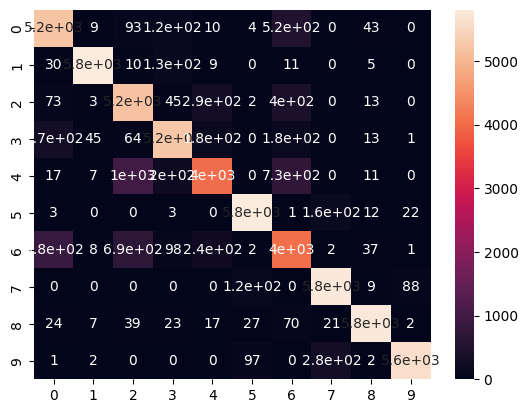

In [235]:
cm = confusion_matrix(test_y.numpy(), pred_test)

plt.figure()
sns.heatmap(cm,annot=True)

print("Accuracy:",accuracy_score(test_y.numpy() ,pred_test) * 100 , "%")

In [242]:
trace_ls_test = []
sims_ls_test = []
for i in tqdm(range(test_x.shape[0])):
    x = test_x[i, :].reshape(1,-1)
    trace, sims = get_trace(x, benchmarks, rt_sim=True)
    trace_ls_test.append(trace)
    sims_ls_test.append(sims)

100%|██████████| 10000/10000 [08:45<00:00, 19.01it/s]


In [243]:
tricky_idx_test = []
for i in tqdm(range(test_x.shape[0])):
    sims = sims_ls_test[i]
    trace = trace_ls_test[i]
    probs = []
    for l in range(len(sims)):
        bayes_prob = get_bayes_from_sim_dict(sim_bayes_dict, l, trace[l], sims[l])
        probs.append(bayes_prob)
    
    prob = np.prod(probs)   # take multiplication of all data as final probability

    # roll god's dice
    dice = random.random()
    if(dice < prob): tricky_idx_test.append(i)

100%|██████████| 10000/10000 [00:01<00:00, 8955.76it/s]


In [244]:
acc_dict_test = dict()
correct_list = [0] * class_num
counter_list = [0] * class_num
for i in range(len(val_y)):
    counter_list[val_y[i]] += 1
    if(int(val_y[i]) == pred_all[-1][i]):
        correct_list[val_y[i]] += 1

for i in range(class_num):
    acc_dict_test[i] = correct_list[i] / counter_list[i]

In [247]:
print("Accuracy on original sample set:",accuracy_score(test_y.numpy() ,pred_test) * 100 , "%")

test_x_tricky = test_x[tricky_idx_test]
test_y_tricky = test_y.numpy()[tricky_idx_test]
preds_test = np.array(predict(mlp,test_x))
test_pred_y_tricky = preds_test[tricky_idx_test]
print("Accuracy on tricky sample set:",accuracy_score(test_y_tricky, test_pred_y_tricky)*100,"%")

test_x_debugged = np.delete(test_x, tricky_idx_test, axis=0)
test_y_debugged = np.delete(test_y.numpy(), tricky_idx_test, axis=0)
test_pred_y_debugged = np.delete(preds_test, tricky_idx_test, axis=0)
print("Accuracy on debugged sample set:",accuracy_score(test_y_debugged, test_pred_y_debugged)*100,"%")

acc_debugged_dict_test = dict()
correct_list_test = [0] * class_num
counter_list_test = [0] * class_num
for i in range(len(test_y_debugged)):
    counter_list_test[test_y_debugged[i]] += 1
    if(int(test_y_debugged[i]) == test_pred_y_debugged[i]):
        correct_list_test[test_y_debugged[i]] += 1

for c in range(class_num):
    acc_debugged_dict_test[c] = correct_list_test[c] / counter_list_test[c]
    print('class %d acc: %f, change: %f' % (c, correct_list_test[c] / counter_list_test[c], acc_debugged_dict_test[c] - acc_dict_test[c]))

Accuracy on original sample set: 87.19 %
Accuracy on tricky sample set: 67.98336798336798 %
Accuracy on debugged sample set: 88.16052106313688 %
class 0 acc: 0.872454, change: 0.011272
class 1 acc: 0.980612, change: 0.015796
class 2 acc: 0.871849, change: 0.012728
class 3 acc: 0.887831, change: 0.014763
class 4 acc: 0.714286, change: 0.048465
class 5 acc: 0.946557, change: -0.007139
class 6 acc: 0.658399, change: -0.000159
class 7 acc: 0.955239, change: -0.001577
class 8 acc: 0.968270, change: 0.006006
class 9 acc: 0.927477, change: 0.006735


Experiment on dataset proves the method is valid.

# Conclusion

1. Firstly, we obtained "benchmarks" for each layer and each class, which are representative feature maps that indicate the most frequent patterns of a class at a certain network hierarchy. For all subsequent validation or testing samples, their feature maps on various levels are compared to the respective benchmark, and the more identical a feature map is to the benchmark, the more likely it belongs to this class. This is accessed quantitatively by "similarity."

2. Secondly, through kernel density estimation plots, we observed a distinct difference between positive and negative samples ("negative samples" here refers to those misclassified in this multi-class scenario) on the distribution of similarity. Negative samples tend to have a smaller similarity with the class benchmark, proving our fundamental assumption that positive and negative samples are subject to different distributions. Meanwhile, we noticed that the distributions are more contrastive on some layers, measured by the Bhattacharyya distance. In other words, some layers divide the positive and the negative well, and they are nominated as Judge Layers.

3. We then used the Bayesian method to convert a sample's similarity with the benchmark into the probability that the sample is negative, given its class is known. However, since the class is unknown, we estimated the probability of a sample's class. To do so, a state-abstraction process, i.e., trace analysis, is implemented. By using the distance function, we can understand how the state of a feature map changes in the network's layers. These traces are structural flow patterns that imply the class information in the early stage of the network. On state traces, we applied the Bayesian method, which provided us with a reasonable conjecture on a sample's class.

4. With class information found out in (3.), we proceeded to find probabilistic thresholds for traces. For instance, if a sample's trace is '4-4-4', which means the state of the feature maps gained by 3 judge layers are all 4 (i.e., all feature maps are closest to class 4's benchmarks), but the similarities are abnormally small (according to KDE, a negative sample tends to have a lower similarity in distribution), it suggests that this sample is of greater possibility to be regarded as a tricky sample, consequently, a higher threshold will be given to this sample.

5. Finally, with different thresholds (positively related to the possibility of being a negative sample) on different samples, ideally, higher on the bug-triggering tricky sample, we picked tricky samples out by random selection (rolling a dice) and ascertained they are tricky samples. Since tricky samples have a higher threshold, they are generally more likely to be picked. Later experiments on the validation set and test set had proven this.

Further improvements can be made on:

- Benchmark generation
    - Rather than mean value with constraints on outliers, is there any other metric that yields a more representative feature map of a class? Now it can be observed that some classes still have similar feature maps on certain layers.
- Distance (similarity) definition
    - The distance function is another pivot of the project. Bhattacharyya distance has been brought up, but in later experiments, it revealed poor computational performance. Therefore, L2 is the only distance metric used all the time. Since benchmarks tend to be hardly differentiable, a deterministic distance function would facilitate finding the correct trace and also Bayesian probability on similarities.
- God's dice (jury computation)
  - After retrieving the Bayesian probability on similarities, the probabilities are multiplied directly to obtain a threshold for rolling the dice. But this approach is oversimplified; the threshold would fluctuate with respect to the layer numbers of the judge layer. For example, if we have 3 judge